# Principal Component Analysis & Feature Selection

## PCA

In [1]:
import pandas as pd
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# https://www.kaggle.com/datasets/saurabh00007/iriscsv
filename = 'Iris.csv'
df = pd.read_csv(filename, index_col=0)
cols_x = list(df.columns[0:4])
col_y = df.columns[4]

# model pipeline for PCA
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('PCA', PCA()),
])
features = df[cols_x]
pipe.fit(features)

# PCA scores
scores = pipe.transform(features)
df_pca = pd.DataFrame(
    scores,
    columns=["PC{}".format(x + 1) for x in range(scores.shape[1])],
    index=df.index
)
cols_pc = list(df_pca.columns)
df_pca.insert(0, col_y, df[col_y].copy())
dfi.export(df_pca.head(), 'table_041_iris_PCA.png')
df_pca.head()

[0105/140338.705047:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[0105/140338.724294:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0105/140338.874988:INFO:headless_shell.cc(623)] Written to file /tmp/tmpf5y_edra/temp.png.


,Species,PC1,PC2,PC3,PC4
Id,,,,,
1,Iris-setosa,-2.264542,0.505704,-0.121943,-0.023073
2,Iris-setosa,-2.086426,-0.655405,-0.227251,-0.103208
3,Iris-setosa,-2.367950,-0.318477,0.051480,-0.027825
4,Iris-setosa,-2.304197,-0.575368,0.098860,0.066311
5,Iris-setosa,-2.388777,0.674767,0.021428,0.037397


# ANOVA

## Raw

In [45]:
import numpy as np
from scipy import stats

list_species = list(set(df_pca[col_y]))
cols_stat = ['F-value', 'p-value']

df_anova = pd.DataFrame(columns=cols_stat)
for x in cols_x:
    args = [df[df[col_y] == list_species[i]][x] for i, species in enumerate(list_species)]
    f_value, p_value = stats.f_oneway(*args)
    result = pd.DataFrame(
        np.array([f_value, p_value]).reshape(1, 2),
        columns=cols_stat,
        index=[x]
    )
    # append row
    df_anova = pd.concat([df_anova, result], axis=0)

print(df_anova)

                   F-value       p-value
SepalLengthCm   119.264502  1.669669e-31
SepalWidthCm     47.364461  1.327917e-16
PetalLengthCm  1179.034328  3.051976e-91
PetalWidthCm    959.324406  4.376957e-85


### Standardize, just in case

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df[cols_x]), columns=cols_x, index=df.index)
df_scaled[col_y] = df[col_y]
print(df_scaled.head())

df_scaled_anova = pd.DataFrame(columns=cols_stat)
for x in cols_x:
    args = [df_scaled[df_scaled[col_y] == list_species[i]][x] for i, species in enumerate(list_species)]
    f_value, p_value = stats.f_oneway(*args)
    result = pd.DataFrame(
        np.array([f_value, p_value]).reshape(1, 2),
        columns=cols_stat,
        index=[x]
    )
    # append row
    df_scaled_anova = pd.concat([df_scaled_anova, result], axis=0)

print(df_scaled_anova)

    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
Id                                                                       
1       -0.900681      1.032057      -1.341272     -1.312977  Iris-setosa
2       -1.143017     -0.124958      -1.341272     -1.312977  Iris-setosa
3       -1.385353      0.337848      -1.398138     -1.312977  Iris-setosa
4       -1.506521      0.106445      -1.284407     -1.312977  Iris-setosa
5       -1.021849      1.263460      -1.341272     -1.312977  Iris-setosa
                   F-value       p-value
SepalLengthCm   119.264502  1.669669e-31
SepalWidthCm     47.364461  1.327917e-16
PetalLengthCm  1179.034328  3.051976e-91
PetalWidthCm    959.324406  4.376957e-85


### bar plot

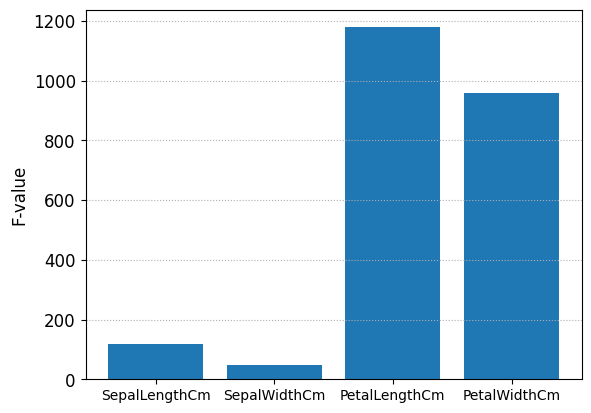

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()
plt.bar(df_anova.index, df_anova['F-value'])
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_ylabel('F-value')
plt.grid(axis='y',linestyle='dotted')
plt.savefig('iris_041_Oneway_ANOVA_raw.png')
plt.show()

## PCA

In [4]:
df_pca_anova = pd.DataFrame(columns=cols_stat)
for pc in cols_pc:
    args = [df_pca[df_pca[col_y] == list_species[i]][pc] for i, species in enumerate(list_species)]
    f_value, p_value = stats.f_oneway(*args)
    result = pd.DataFrame(
        np.array([f_value, p_value]).reshape(1, 2),
        columns=cols_stat,
        index=[pc]
    )
    # append row
    df_pca_anova = pd.concat([df_pca_anova, result], axis=0)

print(df_pca_anova)

         F-value       p-value
PC1  1043.159859  1.412319e-87
PC2    14.429384  1.897877e-06
PC3     5.290448  6.043825e-03
PC4     1.636495  1.981874e-01


### bar plot

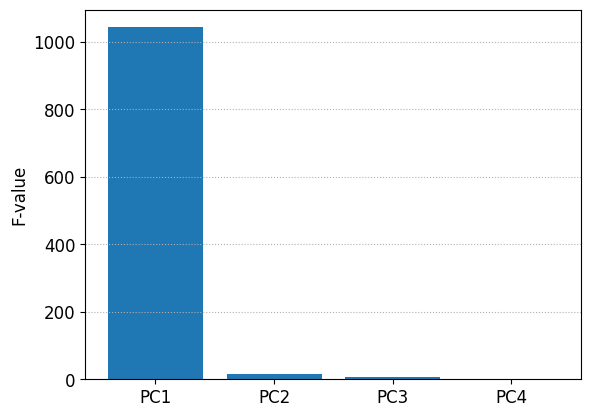

In [16]:
fig, ax = plt.subplots()
plt.bar(df_pca_anova.index, df_pca_anova['F-value'])
ax.set_ylabel('F-value')
plt.grid(axis='y',linestyle='dotted')
plt.savefig('iris_042_Oneway_ANOVA_PCA.png')
plt.show()

## ANOVA for Feature Selection

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=len(cols_pc))
selector.fit(df_pca[cols_pc], df_pca[col_y])
print('scores :   ', selector.scores_)
print('p-values : ', selector.pvalues_)

scores :    [1043.15985867   14.42938424    5.29044846    1.63649473]
p-values :  [1.41231945e-87 1.89787708e-06 6.04382459e-03 1.98187397e-01]


### bar plot

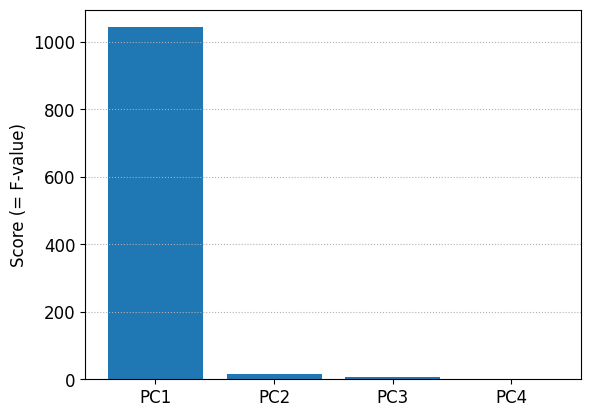

In [19]:
fig, ax = plt.subplots()
plt.bar(cols_pc, selector.scores_)
ax.set_ylabel('Score (= F-value)')
plt.grid(axis='y',linestyle='dotted')
plt.savefig('iris_043_Feature_Selection.png')
plt.show()